<a href="https://colab.research.google.com/github/yarkalm/def_metallization/blob/main/Metallurg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предобработка данных и построение модели определения степени восстановления металла

Импорт библиотек

In [ ]:
import math
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import metrics
from tensorflow import keras
from itertools import product
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Загрузка и преобразование датасета

In [ ]:
df = pd.read_excel('/content/Датасет_металлург.xlsx')
input_data = df[["CO2","CO","H2","Herm","Magn","Temp","Time","m before","m after"]]
output_data = df[["RedDegr"]]
input_data

,CO2,CO,H2,Herm,Magn,Temp,Time,m before,m after
0,80.0,20.0,0.0,0.0,100.0,750,15.0,0.4691,0.3981
1,80.0,20.0,0.0,0.0,100.0,750,30.0,0.4572,0.4126
2,80.0,20.0,0.0,0.0,100.0,750,60.0,0.4682,0.3997
3,80.0,20.0,0.0,0.0,100.0,750,90.0,0.4401,0.3679
4,80.0,20.0,0.0,0.0,100.0,750,120.0,0.4486,0.3715
...,...,...,...,...,...,...,...,...,...
657,76.5,23.0,0.5,0.0,100.0,750,90.0,0.4862,0.4074
658,76.5,23.0,0.5,0.0,100.0,750,120.0,0.4783,0.3926
659,76.5,23.0,0.5,0.0,100.0,750,15.0,0.4766,0.4383
660,76.5,23.0,0.5,0.0,100.0,750,30.0,0.4926,0.4208


проведение корреляционного анализа

In [ ]:
new_df = df[["CO2","CO","H2","Herm","Magn","Temp","Time","m before","m after","RedDegr"]]
corr = new_df.corr().style.background_gradient(cmap='coolwarm')

Разделение на входные и выходные значения

In [ ]:
x = []
y = []
for i in range(len(input_data)):
  tmp = []
  for j in range(len(input_data.iloc[i])):
    tmp.append(np.asarray(input_data.iloc[i].tolist()[j]))
    

  x.append(np.asarray(tmp).astype(np.float32))
  y.append(np.asarray(output_data.iloc[i]/100).astype(np.float32))

Стандартизация данных

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=1)
x_train = np.array(x_train)
x_test = np.array(x_test)
means = x_test.mean(axis=0,dtype=(np.float32))
std = x_test.std(axis=0)

print('Тестовая выборка')
print('Все данные имеют среднее по столбцу: ',*np.round(means,3))
print('Все данные имеют дисперсию по столбцу: ',*np.round(std,3))

Тестовая выборка
Все данные имеют среднее по столбцу:  58.389 27.328 7.018 3.762 96.238 778.639 61.807 0.496 0.433
Все данные имеют дисперсию по столбцу:  31.357 20.619 20.415 16.314 16.314 39.679 41.031 0.018 0.031


In [ ]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
print('Тестовая выборка')
print('Все данные имеют среднее по столбцу: ',np.round_(x_test.mean(axis=0,dtype=(np.float32)),6))
print('Все данные имеют дисперсию по столбцу: ',x_test.std(axis=0))

Тестовая выборка
Все данные имеют среднее по столбцу:  [ 0.  0. -0. -0.  0. -0. -0.  0.  0.]
Все данные имеют дисперсию по столбцу:  [0.99999994 1.0000002  0.9999998  1.0000006  1.0000006  1.0000002
 1.0000002  1.         1.0000001 ]


# Подбор лучших параметров для ИНС

Словарь различных параметров для ИНС

In [ ]:
par = {'layer_1': ['tanh','sigmoid','relu'],
          'layer_2': ['tanh','sigmoid','relu'],
          'layer_3': ['tanh','sigmoid','relu'],
          'layer_4': ['tanh','sigmoid','relu'],
          'layer_5': ['tanh','sigmoid','relu'],
          'epochs':[5,15,25],
          'opt': [keras.optimizers.SGD(0.1),keras.optimizers.Adam(0.1)]
          }

Список всех возможных комбинаций параметров

In [ ]:
combinations = list(product(*par.values()))
print("Количество различных комбинаций:",len(combinations))

Количество различных комбинаций: 1458


In [ ]:
combinations[69]   # Пример комбинации

('tanh',
 'tanh',
 'relu',
 'softmax',
 'exponential',
 15,
 <keras.optimizers.optimizer_v2.adam.Adam at 0x7ff1f6c44cd0>)

- Перебор различных комбинаций

In [ ]:
variant = 0   # Счётчик варианта ИНС
models = {}   # Словарь всех вариантов моделей ИНС



""" Метрика точности (доля верных предсказаний в сравнении с реальными значениями)"""
def my_metric(y_true, y_pred):
  return (100 - 100 * abs((y_true - y_pred) / y_true))



""" Цикл перебора комбинаций"""
for cmb in combinations:

  print("---------------------------------------------------------------------")
  print(f"Variant #{variant}")    # Номер варианта (комбинации)
  variant+=1



  #   Строение модели
  model = keras.Sequential()
  model.add(keras.Input(shape=(9,)))
  model.add(Dense(units = 9, activation=cmb[0]))
  model.add(Dense(units = 7, activation=cmb[1]))
  model.add(Dense(units = 5, activation=cmb[2]))
  model.add(Dense(units = 3, activation=cmb[3]))
  model.add(Dense(units = 1, activation=cmb[4]))

  model.compile(loss='mean_squared_error',optimizer = cmb[6],metrics=[my_metric])
  history=model.fit((np.array(x_train))[0:100],(np.array(y_train))[0:100],validation_split = 0.2,verbose=0,epochs = cmb[5])



  fig = plt.figure(figsize=(16, 4))
  ax = fig.add_subplot(121)
  ax.plot(history.history['my_metric'],'--',color='black')
  ax.plot(history.history['val_my_metric'],color='black')
  ax.set_title('График точности')
  ax.set_ylabel('accuracy')
  ax.set_xlabel('epoch')
  ax.legend(['train', 'test'], loc='upper left')
  ax.grid(True)


  ax2 = fig.add_subplot(122)
  ax2.plot(history.history['loss'],'--',color='black')
  ax2.plot(history.history['val_loss'],color='black')
  ax2.set_title('График функции потерь')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')
  ax2.legend(['train', 'test'], loc='upper left')
  ax2.grid(True)
  plt.show()

  pred = model.predict(np.array(x_test)) # Предсказанные данные

  #   Оценка точности варианта(комбинации) на тестовом наборе 
  mape = 1-sklearn.metrics.mean_absolute_percentage_error(y_test, pred)



  score = model.evaluate(np.array(x_test), np.array(y_test),batch_size=9)
  print(f" layer 1:{cmb[0]} \n layer 2:{cmb[1]} \n layer 3:{cmb[2]} \n layer 4:{cmb[3]} \n layer 5:{cmb[4]} \n epochs:{cmb[5]} \n opt:{cmb[6]}")
  
  print(f"Variant score : {mape*100}%")
  


  """ Сохранение модели и информации о модели"""
  models[variant]=[cmb[0],cmb[1],cmb[2],cmb[3],cmb[4],cmb[5],cmb[6],score[0],mape,history]
  model.save(f'model{variant}')
  print()
  print()
  print()

Таблица комбинаций параметров всех вариантов(комбинаций) ИНС и их результатов 

In [ ]:
params = pd.DataFrame.from_dict(models,orient='index').rename(columns={0:'layer_1',1:'layer_2',2:'layer_3',3:'layer_4',4:'layer_5',5:'Number of epochs',6:'Optimizer',7:'Loss',8:'Accuracy',9:'History'})
pd.set_option("display.max_rows", None, "display.max_columns", None)
params.sort_values('Accuracy').tail(10)

Лучший вариант набора параметров по минимальному значению функции ошибки

In [ ]:
best_pr = params.iloc[params['Loss'].values.argmin()]
best_index = params[['Loss']].idxmin()
best_pr

# Воссоздание лучшей модели

In [ ]:
""" Метрика точности (доля верных предсказаний в сравнении с реальными значениями)"""
def my_metric(y_true, y_pred):
  return (100 - 100 * abs((y_true - y_pred) / y_true))


# Загружаем оптимальную модель
model = keras.models.load_model(f'model{best_index[0]}',custom_objects={"my_metric": my_metric},compile = False)
   
pred = model.predict(np.array(x_test))
       
print(f"layer 1:{best_pr[0]} \n layer 2:{best_pr[1]} \n layer 3:{best_pr[2]} \n epochs:{best_pr[3]} \n opt:{best_pr[4]}")
  
print(f"Variant accuracy: {1-sklearn.metrics.mean_absolute_percentage_error(y_test,pred)}")

In [ ]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(121)
ax.plot(best_pr[8].history['my_metric'],'--',color='black')
ax.plot(best_pr[8].history['val_my_metric'],color='black')
ax.set_title('График точности')
ax.set_ylabel('Accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper left')
ax.grid(True)


ax2 = fig.add_subplot(122)
ax2.plot(best_pr[8].history['loss'],'--',color = 'black')
ax2.plot(best_pr[8].history['val_loss'],color = 'black')
ax2.set_title('График функции потерь')
ax2.set_ylabel('Loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
ax2.grid(True)
plt.show()

# Кросс-валидация

0 221
-1 661
X_tr 441
X_t 221
662
7/7 [==============================] - 0s 2ms/step


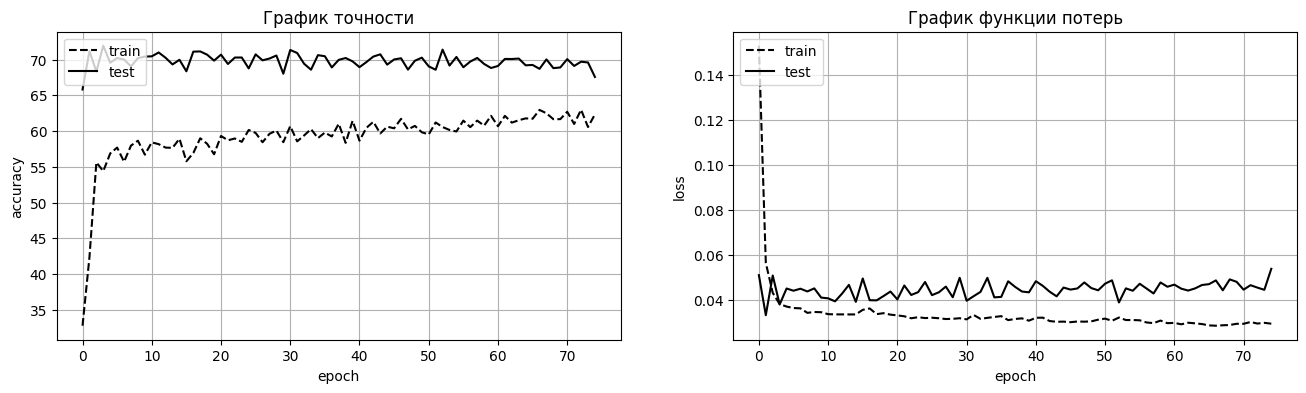

0 0
-1 661
X_tr 662
X_t 221
883
7/7 [==============================] - 0s 3ms/step


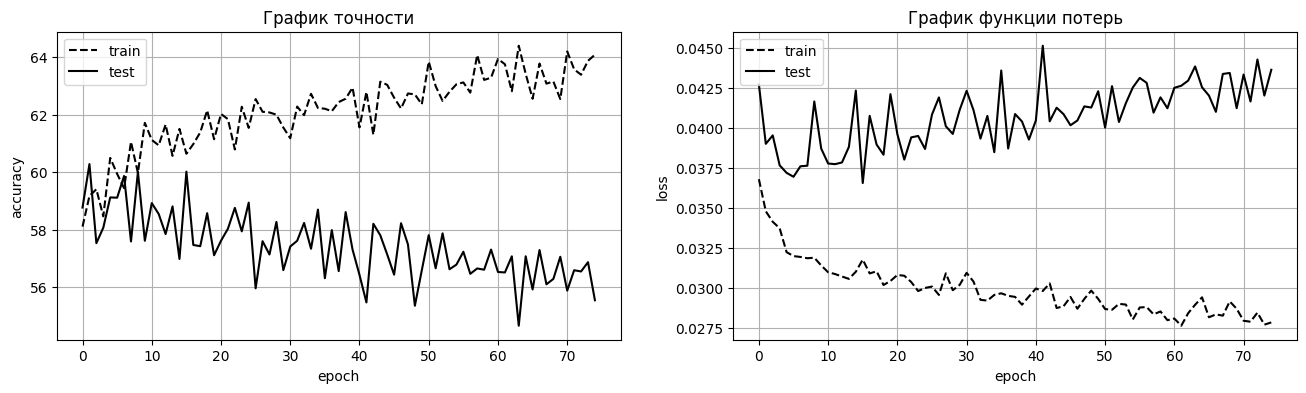

0 0
-1 441
X_tr 442
X_t 220
662
7/7 [==============================] - 0s 3ms/step


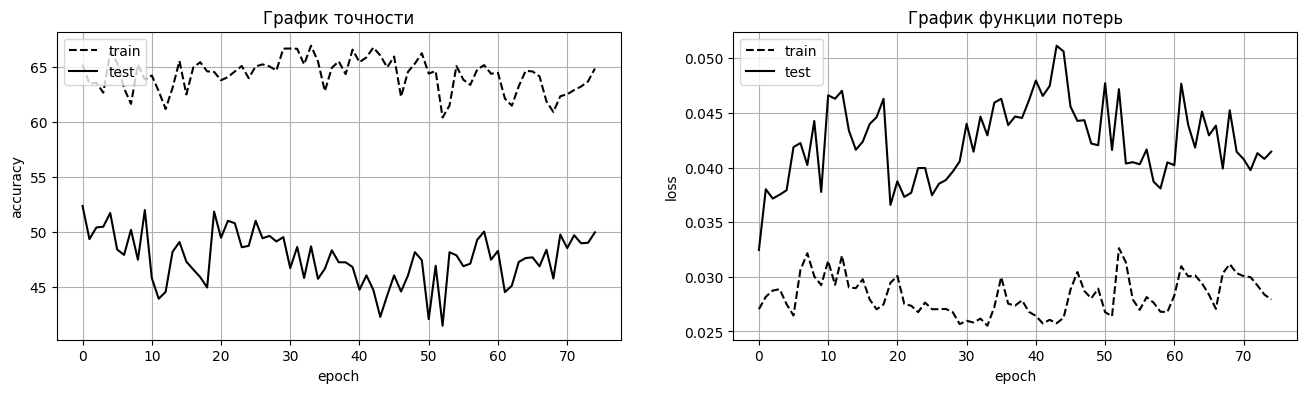

6/6 [==============================] - 0s 6ms/step
166
166
Variant accuracy: 0.49554944038391113


In [ ]:
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score
 
test_x = np.concatenate([x_train, x_test]) 
def my_metric(y_true, y_pred):
  return (100 - 100 * abs((y_true - y_pred) / y_true))

 
#Implementing cross validation
 
k = 3
kf = KFold(n_splits=k, random_state=None)
model = keras.Sequential()
model.add(keras.Input(shape=(9,)))
model.add(Dense(units = 256, activation='tanh'))
model.add(Dense(units = 128, activation='tanh'))
model.add(Dense(units = 64, activation='tanh'))
model.add(Dense(units = 32, activation='tanh'))
model.add(Dense(units = 16, activation='tanh'))
model.add(Dense(units = 4, activation='tanh'))
model.add(Dense(units = 2, activation='tanh'))
model.add(Dense(units = 1, activation='tanh'))

model.compile(loss='mean_squared_error',optimizer = keras.optimizers.Adam(0.001),metrics=[my_metric])

 
for train_index , test_index in kf.split(test_x):
  print('Начальный индекс',train_index[0])
  print('Конечный индекс',train_index[-1])
  X_train , X_test = test_x[train_index[0]:train_index[-1]+1],test_x[test_index[0]:test_index[-1]+1]
  Y_train , Y_test = y[train_index[0]:train_index[-1]+1] , y[test_index[0]:test_index[-1]+1]
  print('Длина обучающей части',len(X_train))
  print('Длина тестовой части',len(X_test))
  print(len(X_train)+len(X_test))


  history=model.fit((np.array(X_train)),(np.array(Y_train)),validation_split = 0.2,verbose=0,epochs = 75) 

  pred_values = model.predict(X_test)
  fig = plt.figure(figsize=(16, 4))
  ax = fig.add_subplot(121)
  ax.plot(history.history['my_metric'],'--',color='black')
  ax.plot(history.history['val_my_metric'],color='black')
  ax.set_title('График точности')
  ax.set_ylabel('accuracy')
  ax.set_xlabel('epoch')
  ax.legend(['train', 'test'], loc='upper left')
  ax.grid(True)

  ax2 = fig.add_subplot(122)
  ax2.plot(history.history['loss'],'--',color='black')
  ax2.plot(history.history['val_loss'],color='black')
  ax2.set_title('График функции потерь')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')
  ax2.legend(['train', 'test'], loc='upper left')
  ax2.grid(True)
  plt.show()

   
pred = model.predict(np.array(x_test))
print(len(x_test))
print(len(y_test))
print(f"Variant accuracy: {1-sklearn.metrics.mean_absolute_percentage_error(y_test,pred)}")
     


# Конечная версия модели

После того как была выявлена лучшая структура, была разработана и обученная оптимальная модель


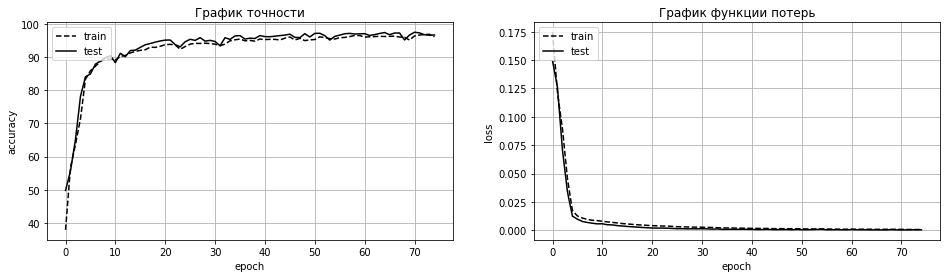

6/6 [==============================] - 0s 3ms/step
Variant accuracy: 0.9662983790040016


In [ ]:
""" Метрика точности (доля верных предсказаний в сравнении с реальными значениями)"""
def my_metric(y_true, y_pred):
  return (100 - 100 * abs((y_true - y_pred) / y_true))


# Загружаем оптимальную модель
model = keras.Sequential()
model.add(keras.Input(shape=(9,)))
model.add(Dense(units = 256, activation='tanh'))
model.add(Dense(units = 128, activation='tanh'))
model.add(Dense(units = 64, activation='tanh'))
model.add(Dense(units = 32, activation='tanh'))
model.add(Dense(units = 16, activation='tanh'))
model.add(Dense(units = 4, activation='tanh'))
model.add(Dense(units = 2, activation='tanh'))
model.add(Dense(units = 1, activation='tanh'))

model.compile(loss='mean_squared_error',optimizer = keras.optimizers.Adam(0.001),metrics=[my_metric])
history=model.fit((np.array(x_train))[0:600],(np.array(y_train))[0:600],validation_split = 0.2,verbose=0,epochs = 75)

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(121)
ax.plot(history.history['my_metric'],'--',color='black')
ax.plot(history.history['val_my_metric'],color='black')
ax.set_title('График точности')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper left')
ax.grid(True)


ax2 = fig.add_subplot(122)
ax2.plot(history.history['loss'],'--',color='black')
ax2.plot(history.history['val_loss'],color='black')
ax2.set_title('График функции потерь')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
ax2.grid(True)
plt.show()

   
pred = model.predict(np.array(x_test))
print(f"Variant accuracy: {1-sklearn.metrics.mean_absolute_percentage_error(y_test,pred)}")

In [ ]:
#   Описание модели
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,show_layer_activations = True)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 256)               2560      
                                                                 
 dense_25 (Dense)            (None, 128)               32896     
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 dense_27 (Dense)            (None, 32)                2080      
                                                                 
 dense_28 (Dense)            (None, 16)                528       
                                                                 
 dense_29 (Dense)            (None, 4)                 68        
                                                                 
 dense_30 (Dense)            (None, 2)                

# Таблица предсказаний ИНС в сравнении с реальными данными и их абсолютная разница

In [ ]:
y_pred = []
y_real = []
mae = []
perc = []
for i in range(len(x_train)):
  y_pred.append(model.predict(x_train[[i]]))
  y_real.append(y_train[i])
for i in range(len(x_test)):
  y_pred.append(model.predict(x_test[[i]]))
  y_real.append(y_test[i])  
for i in range(len(y_pred)):
  mae.append(abs(y_real[i]-y_pred[i]))
  perc.append(100*mae[i]/y_real[i])

test = pd.DataFrame()
test['Предсказанные']=y_pred
test['Предсказанные'] = test['Предсказанные'].str.get(0).str.get(0)
test['Истинные']=y_real
test['Истинные']=test['Истинные'].str.get(0)
test['Ошибка'] = mae
test['Ошибка'] = test['Ошибка'].str.get(0).str.get(0)
test['Отклонение %'] = perc
test['Отклонение %'] = test['Отклонение %'].str.get(0)
test = test.astype(float)
pd.set_option("display.max_rows", None, "display.max_columns", None)
test

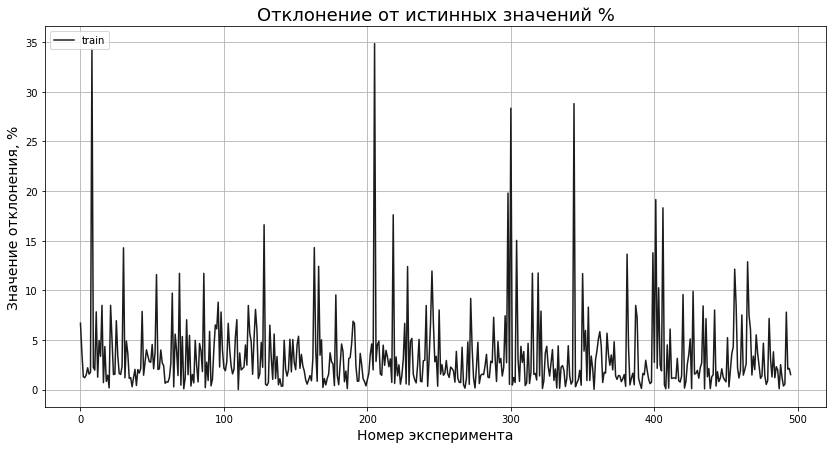

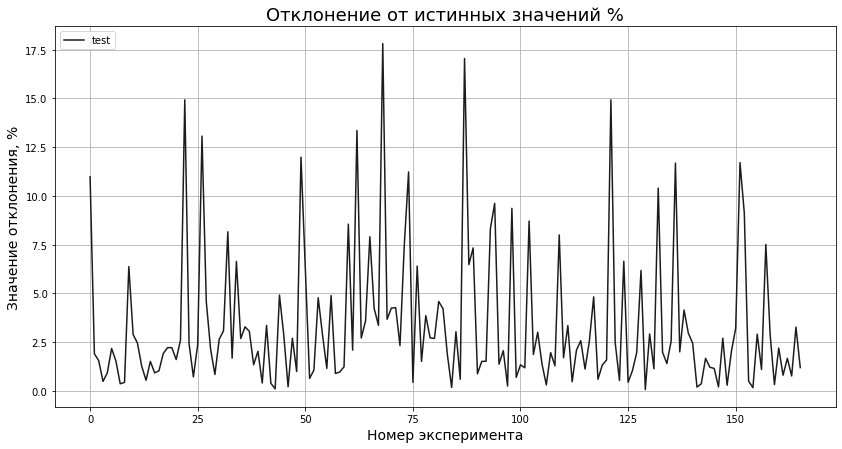

In [ ]:
# График отклонения от истинных значений в % на обучающей выборке
plt.figure(figsize=(14, 7))
plt.plot(list(range(len(x_train))),test["Отклонение %"].head(len(x_train)),color='#1C1C1C')
plt.title('Отклонение от истинных значений %', fontsize=18)
plt.ylabel('Значение отклонения, %', fontsize=14)
plt.xlabel('Номер эксперимента', fontsize=14)
plt.legend(['train'], loc='upper left')
plt.grid(True)
plt.savefig("train.png")
plt.show()

# График отклонения от истинных значений в % на обучающей выборке
plt.figure(figsize=(14, 7))
plt.plot(list(range(len(x_test))),test["Отклонение %"].tail(len(y_test)),color='#1C1C1C')
plt.title('Отклонение от истинных значений %', fontsize=18)
plt.ylabel('Значение отклонения, %', fontsize=14)
plt.xlabel('Номер эксперимента', fontsize=14)
plt.legend(['test'], loc='upper left')
plt.grid(True)
plt.savefig("test.png")
plt.show()

**Вывод: Для повышения точности необходимо увеличить исходный датасет** 

* Выгрузка результатов

In [ ]:
test.to_excel("out.xlsx")